In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit
from functools import reduce

%matplotlib inline

In [2]:
path = '/Users/rshara01/WORK/BLD/data/'
#names = ['bld_20072024.csv','bld_21072024.csv']
#names = ['bld_30102024.csv','bld_05112024.csv','bld_03122024.csv']
names = ['bld_18122024.csv','bld_18122024_2.csv']
dfs = [pd.read_csv(r'%s%s'%(path,name)) for name in names]

In [3]:
devlist = [col for col in dfs[0].columns if col.find('tstamp')==-1]
print(dfs[1].columns)

Index(['tstamp_L:D03BDM', 'L:D03BDM', 'tstamp_L:D03BDS', 'L:D03BDS',
       'tstamp_L:D03HV1', 'L:D03HV1', 'tstamp_L:D03HV2', 'L:D03HV2',
       'tstamp_L:DDMOT3', 'L:DDMOT3', 'tstamp_L:DDMOT4', 'L:DDMOT4',
       'tstamp_L:V1QSET', 'L:V1QSET', 'tstamp_L:V2QSET', 'L:V2QSET',
       'tstamp_L:V3QSET', 'L:V3QSET', 'tstamp_L:V4QSET', 'L:V4QSET',
       'tstamp_L:V5QSET', 'L:V5QSET', 'tstamp_L:L0PADJ', 'L:L0PADJ',
       'tstamp_L:C0PHAS', 'L:C0PHAS', 'tstamp_L:LVPADJ', 'L:LVPADJ',
       'tstamp_L:CVPHAS', 'L:CVPHAS'],
      dtype='object')


In [4]:
#concat the two files - part of the same dataset
totdf = pd.concat(dfs)

In [5]:

ll = []
for dev in devlist:
    dfdev= totdf[['%s'%dev,'tstamp_%s'%dev]].copy()
    dfdev['tstamp_%s'%dev]= pd.to_datetime(dfdev['tstamp_%s'%dev],unit='s',utc=True,errors='coerce')
    #dfdev['TS']=dfdev['tstamp_%s'%dev].dt.tz_convert('US/Central')
    #dfdev['TS'] = dfdev['TS'].dt.strftime('%x %X.%f')
    #dfdev.rename(columns={'tstamp_%s'%dev:'tstamp','TS':'Timestamp %s'%dev},inplace=True)
    dfdev['tstamp_%s'%dev]=dfdev['tstamp_%s'%dev].dt.tz_convert('US/Central')
    dfdev.rename(columns={'tstamp_%s'%dev:'tstamp'},inplace=True)
    dfdev.dropna(inplace=True)
    ll.append(dfdev)

ddf = reduce(lambda  left,right: pd.merge_asof(left.sort_values('tstamp'),right.sort_values('tstamp'),
                                               on=['tstamp'],direction='nearest',tolerance=pd.Timedelta('500ms')), ll)
#ddf.drop(columns=['tstamp'], inplace=True)
ddf.dropna(inplace=True)

In [6]:
ddf.dropna(inplace=True)
ddf.shape

(1602, 16)

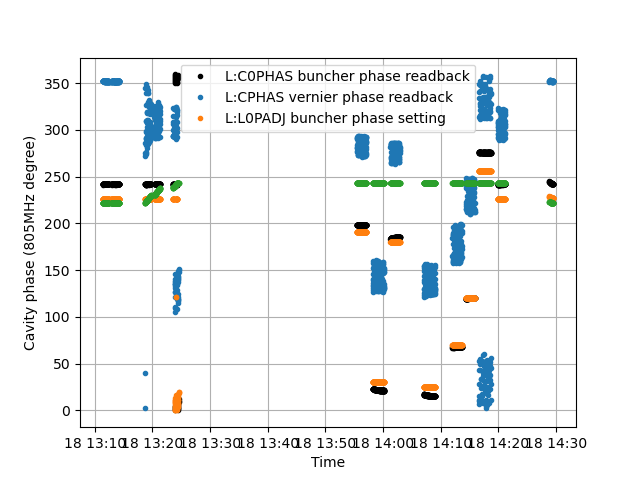

In [7]:
%matplotlib widget
plt.cla()

plt.plot(ddf['tstamp'],ddf['L:C0PHAS'],'k.',label='L:C0PHAS buncher phase readback')
plt.plot(ddf['tstamp'],ddf['L:CVPHAS'],'.',label='L:CPHAS vernier phase readback')
plt.plot(ddf['tstamp'],ddf['L:L0PADJ'],'.',label='L:L0PADJ buncher phase setting')
plt.plot(ddf['tstamp'],ddf['L:LVPADJ'],'.')
plt.xlabel('Time')
plt.ylabel('Cavity phase (805MHz degree)')
plt.grid()
plt.legend()


plt.show()

In [8]:
#ddf.to_csv('bld_05112024_merged.csv')

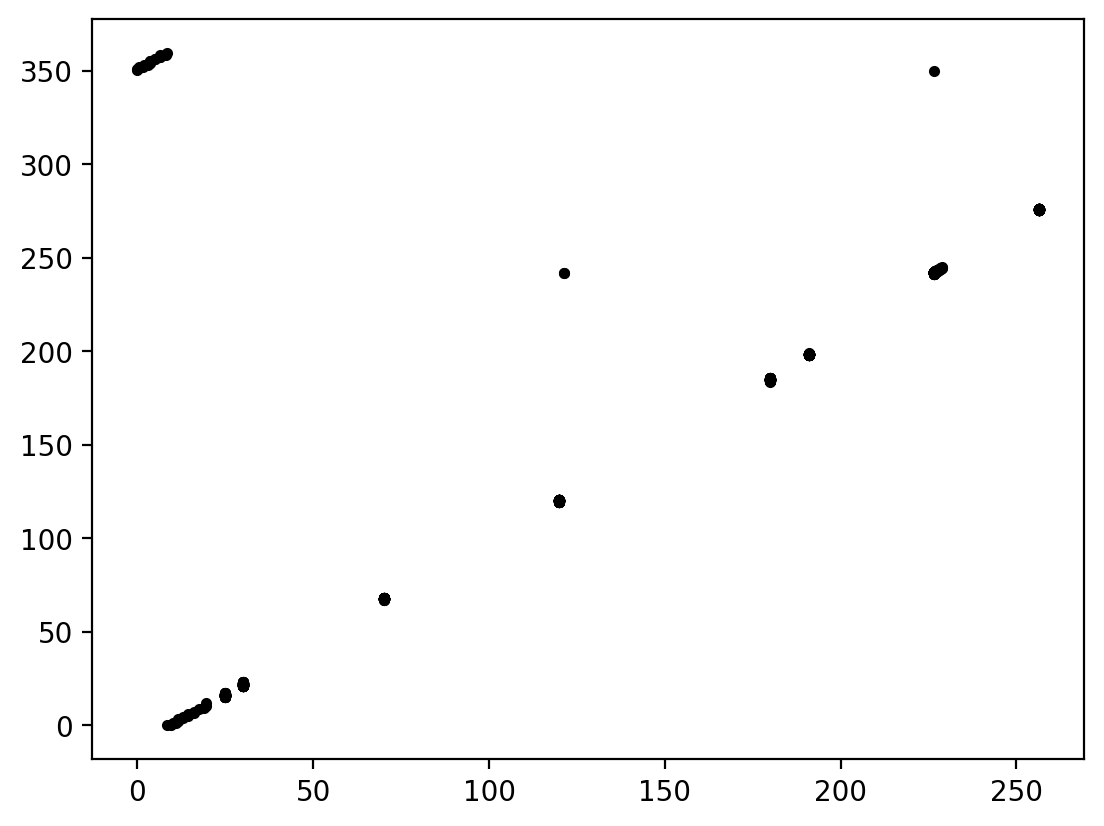

In [9]:
%matplotlib inline
plt.cla()

plt.plot(ddf['L:L0PADJ'],ddf['L:C0PHAS'],'k.')
plt.show()

In [10]:
t_df = []

#timeslices = [['09:00:00','09:06:00'],['09:12:00','09:15:00'],['09:19:00','09:22:00']]
#timeslices = [['11:49','11:54'],['11:59','12:01'],['12:06','12:08'],['12:10','12:12'],
#              ['12:14','12:16'],['12:18','12:22'],['12:34','12:36'],['12:42','12:44']]
#timeslices = [['12:27:30','12:29:00'],['12:32:00','12:34:00'],['12:35:00','12:37:00'],['12:39:00','12:42:00']]
timeslices = [['13:19','13:21:30'],['13:55','13:57'],['13:58','14:00'],['14:01','14:03'],
              ['14:07','14:09'],['14:12','14:13:30'],['14:14','14:16'],['14:16','14:18:30'],['14:19:30','14:21:50']]
for ts in timeslices:
    mask = (ddf['tstamp'].dt.time >= pd.Timestamp(ts[0]).time()) & (ddf['tstamp'].dt.time <= pd.Timestamp(ts[1]).time())
    mask2 = (ddf['L:DDMOT3']>25.) & (ddf['L:DDMOT3']<75.)
    t_df.append(ddf.loc[mask].loc[mask2])

In [11]:
fwhm = []
for t in t_df:
    peaks, _ = find_peaks(t['L:D03BDS'],prominence=0.9)
    widths, heights, left_ips, right_ips = peak_widths(t['L:D03BDS'], peaks, rel_height=0.6)
    
    fwhm.append(t['L:DDMOT3'].iloc[round(right_ips[0])]- t['L:DDMOT3'].iloc[round(left_ips[0])])
    print(peaks,widths,heights, left_ips,right_ips)
    print('FWHM ', fwhm[-1])


[75] [38.22402007] [0.68658447] [50.22744186] [88.45146193]
FWHM  -5.172578129999998
[64] [32.45036688] [0.63714599] [43.589339] [76.03970588]
FWHM  3.9743847700000003
[61] [48.49518259] [0.55218506] [36.7976009] [85.29278348]
FWHM  -9.64432617
[68] [23.22253949] [0.66326904] [58.20439121] [81.4269307]
FWHM  3.7844824200000033
[64] [59.44580787] [0.62573242] [39.60506325] [99.05087112]
FWHM  -9.28712891
[65] [37.72823952] [0.65484619] [48.1113978] [85.83963732]
FWHM  7.844775389999995
[38] [29.34833441] [0.68572998] [22.42996747] [51.77830188]
FWHM  -5.877929690000002
[88] [38.92737704] [0.7300415] [68.97519908] [107.90257612]
FWHM  6.099482420000001
[55] [23.61597385] [0.76123047] [42.01637629] [65.63235014]
FWHM  -4.729472660000006


In [63]:
comb = pd.concat(t_df)
comb.to_csv('bld_18122024_buncher.csv')

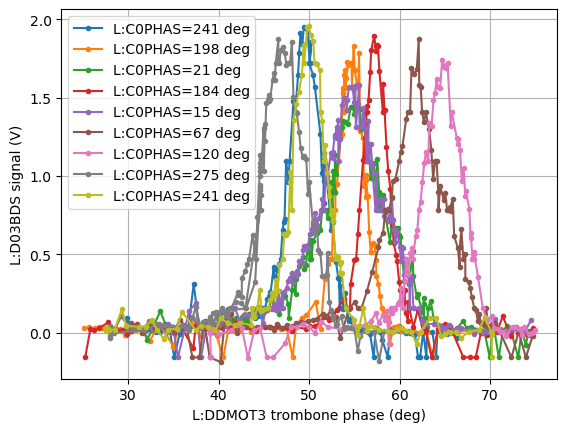

In [13]:
plt.cla()
%matplotlib inline
i=0
for d in t_df:
    plt.plot(d['L:DDMOT3'],d['L:D03BDS'],'.-',label='L:C0PHAS=%d deg'%d['L:C0PHAS'].mean());
    #plt.plot(d['L:D03BDS'],'.-',label='L:C0PHAS=%d deg'%d['L:C0PHAS'].mean());
    #plt.hlines(heights, left_ips, right_ips, color="C2")
plt.xlabel('L:DDMOT3 trombone phase (deg)')
plt.ylabel('L:D03BDS signal (V)')
plt.grid()
plt.legend()
plt.show()

5
4.439320172632413 8.527485389153178
3.4734293344412173 6.439122579509237
8.242901109114966 10.805204309822223
3.1775447714192806 6.056898974638201
8.212155009542638 11.802918845134421
7.014904246771268 10.855159136515205
5.194809591993922 9.006335351533306
5.378586910902912 10.101597620643236
4.250461667536854 8.30102220066641


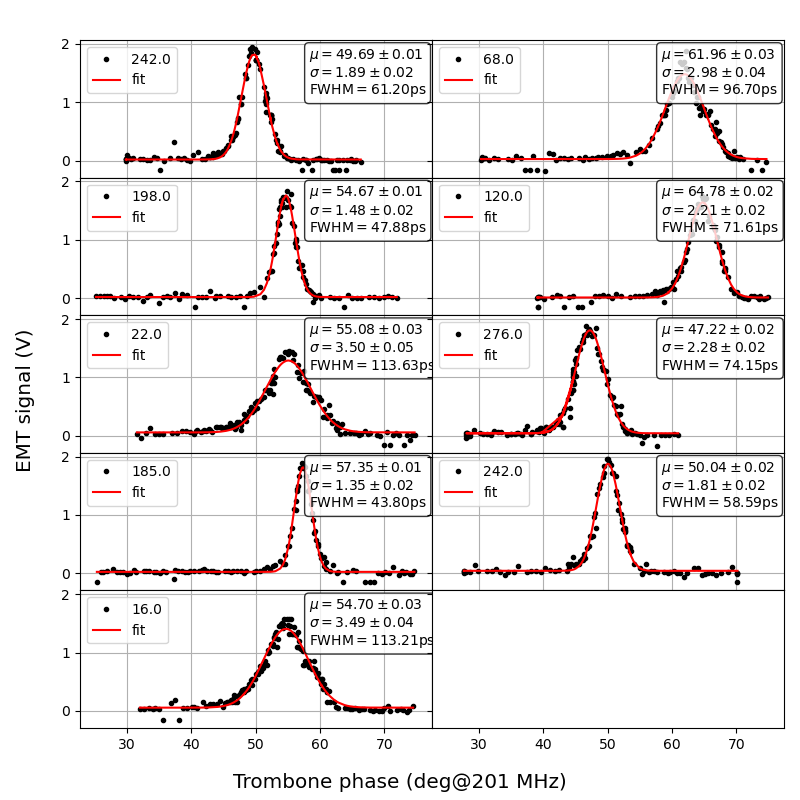

In [47]:
def gauss(x, H, A, x0, sigma):
    #return 0.75 + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y, e):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma], sigma=e, absolute_sigma=True)

    return popt,pcov


rms = np.std(t_df[0]['L:D03BDS'].iloc[:10])

x0 = np.zeros(len(t_df))
sigma = np.zeros(len(t_df))
x0err = np.zeros(len(t_df))
sigmaerr = np.zeros(len(t_df))
integral = np.zeros(len(t_df))
A = np.zeros(len(t_df))
c0phas = [np.round(t['L:C0PHAS'].mean()) for t in t_df]

import scipy.integrate as integrate

%matplotlib widget

numcol = int(len(t_df)/2) if len(t_df)%2==0 else int(len(t_df)/2)+1
print(numcol)
fig2,axs = plt.subplots(numcol,2,figsize=(8,16/2),sharex=True,sharey=True)
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

for j in range(len(t_df)):
    errors = np.ones(len(t_df[j]['L:D03BDS']))*rms
    (H, A[j], x0[j], sigma[j]),pcov = gauss_fit(t_df[j]['L:DDMOT3'], t_df[j]['L:D03BDS'], errors)
    FWHM = 2.35482 * sigma[j]
    ps = 1./201.5e6 * FWHM/360. * 1e12
    #integral[j] = integrate.cumulative_trapezoid(gauss(t_df[j]['L:DDMOT3'],H,A[j],x0[j],sigma[j]),t_df[j]['L:DDMOT3'])[-1]
    integral[j] = A[j]*sigma[j]*np.sqrt(2*np.pi)
    print(FWHM, abs(integral[j]))
    
    x0err[j] = np.sqrt(pcov[2][2])
    sigmaerr[j] = np.sqrt(pcov[3][3])
    textstr = '\n'.join((
            r'$\mu=%.2f\pm%.2f$' % (x0[j], np.sqrt(pcov[2][2]),),
            r'$\sigma=%.2f\pm%.2f$' % (sigma[j], np.sqrt(pcov[3][3]),),
            r'$\mathrm{FWHM}=%.2f\mathrm{ps}$' % (ps, )))

    axs[int(j%(len(t_df)/2))][int(j/(len(t_df)/2))].plot(t_df[j]['L:DDMOT3'], t_df[j]['L:D03BDS'], '.',color='k', label='%s'%c0phas[j])
    axs[int(j%(len(t_df)/2))][int(j/(len(t_df)/2))].plot(t_df[j]['L:DDMOT3'], gauss(t_df[j]['L:DDMOT3'], *gauss_fit(t_df[j]['L:DDMOT3'], 
                t_df[j]['L:D03BDS'], errors)[0]), '-',color='r', label='fit')
    axs[int(j%(len(t_df)/2))][int(j/(len(t_df)/2))].grid(True)
    axs[int(j%(len(t_df)/2))][int(j/(len(t_df)/2))].legend()
    axs[int(j%(len(t_df)/2))][int(j/(len(t_df)/2))].text(0.65, 0.95, textstr, transform=axs[int(j%(len(t_df)/2))][int(j/(len(t_df)/2))].transAxes, color='k', fontsize='medium',
                           verticalalignment='top', bbox=props)

fig2.supylabel('EMT signal (V)',fontsize='x-large')
fig2.supxlabel('Trombone phase (deg@201 MHz)',fontsize='x-large')
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplots_adjust(bottom=0.09)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(left=0.10)
plt.subplots_adjust(right=0.98)
plt.show()        

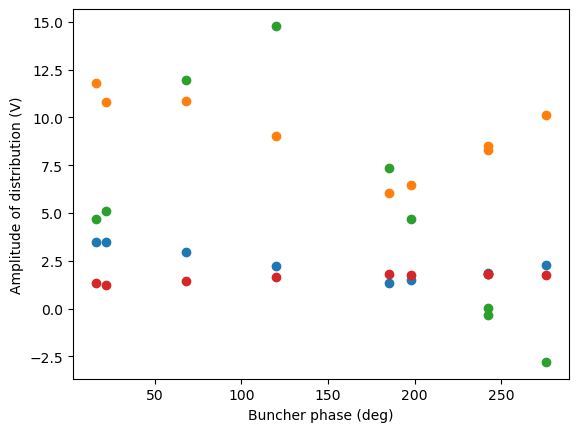

In [51]:
plt.cla()
%matplotlib inline
plt.cla()

plt.scatter(c0phas,sigma)
plt.scatter(c0phas,abs(integral))
plt.scatter(c0phas,x0-50)
plt.scatter(c0phas,A)
plt.xlabel('Buncher phase (deg)')
#plt.ylabel('Gaus sigma (201MHz deg)')
#plt.ylabel('Integral (V x 201MHz degrees)')
plt.ylabel('Amplitude of distribution (V)')
plt.show()

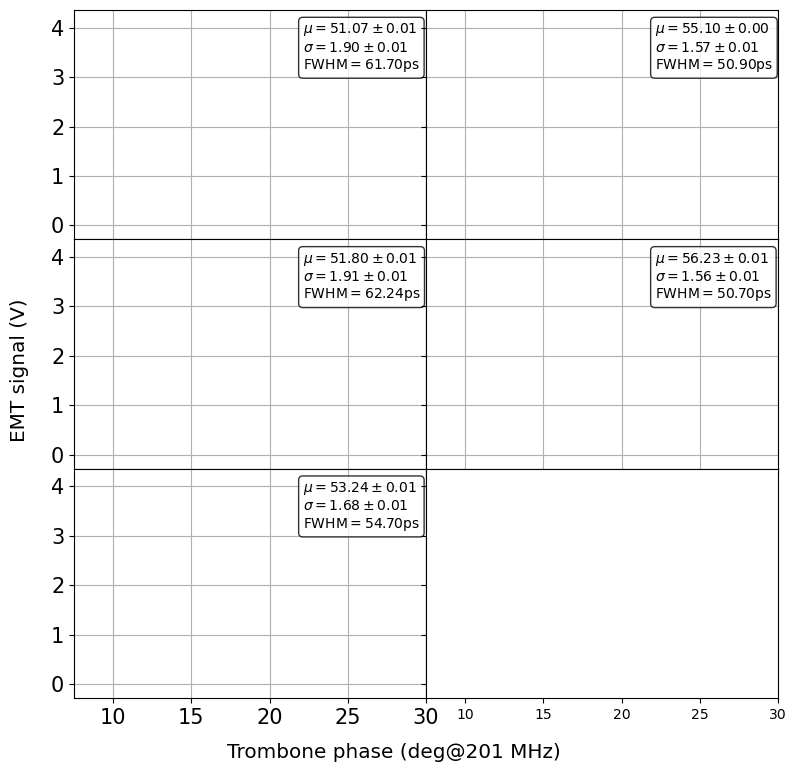

In [170]:
%matplotlib inline
xdata = [t['L:DDMOT3'] for t in t_df]
ydata = [t['L:D03BDS'] for t in t_df]


numcol = int(len(xdata)/2) if len(xdata)%2==0 else int(len(xdata)/2)+1
fig2,axs = plt.subplots(numcol,2,figsize=(8,16/2),sharex=True,sharey=True)
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

x0 = np.zeros(len(xdata),dtype=float)
x0err = np.zeros(len(xdata),dtype=float)
sigma = np.zeros(len(xdata),dtype=float)
sigmaerr = np.zeros(len(xdata),dtype=float)

for i,xd in enumerate(xdata):
    
    errors = np.ones(len(ydata[i]))*rms
    (H, A, x0[i], sigma[i]),pcov = gauss_fit(xdata[i], ydata[i], errors)
    FWHM = 2.35482 * sigma[i]
    ps = 1./201.24e6 * FWHM/360. * 1e12
    textstr = '\n'.join((
            r'$\mu=%.2f\pm%.2f$' % (x0[i], np.sqrt(pcov[2][2]),),
            r'$\sigma=%.2f\pm%.2f$' % (sigma[i], np.sqrt(pcov[3][3]),),
            r'$\mathrm{FWHM}=%.2f\mathrm{ps}$' % (ps, )))

    #phasestr = '\n'.join([r'T%i=%.1f'%(iphas+1,phas) for iphas,phas in enumerate(phases[i])])
    #print(phasestr)
    
    x0err[i] = np.sqrt(pcov[2][2])
    sigmaerr[i] = np.sqrt(pcov[3][3])
    
    axs[int(i%(len(xdata)/2))][int(i/(len(xdata)/2))].plot(xd,ydata[i],marker='.',linestyle='none',color='k')
    axs[int(i%(len(xdata)/2))][int(i/(len(xdata)/2))].plot(xd, gauss(xd, *gauss_fit(xd, ydata[i], errors)[0]), '-',color='r', label='fit %d'%i)

    if i==0:
        axs[int(i%(len(xdata)/2))][int(i/(len(xdata)/2))].set_xlim(7.5,30)
    axs[int(i%(len(xdata)/2))][int(i/(len(xdata)/2))].tick_params(axis='both',labelsize=15)
    
    axs[int(i%(len(xdata)/2))][int(i/(len(xdata)/2))].grid(True)
    axs[int(i%(len(xdata)/2))][int(i/(len(xdata)/2))].text(0.65, 0.95, textstr, transform=axs[int(i%(len(xdata)/2))][int(i/(len(xdata)/2))].transAxes, color='k', fontsize='medium',
                           verticalalignment='top', bbox=props)
    #axs[int(i%(len(xdata)/2))][int(i/(len(xdata)/2))].text(0.02, 0.95, phasestr, transform=axs[int(i%(len(xdata)/2))][int(i/(len(xdata)/2))].transAxes, color='k', fontsize='large',
    #                       verticalalignment='top', bbox=props)
    
    
fig2.supylabel('EMT signal (V)',fontsize='x-large')
fig2.supxlabel('Trombone phase (deg@201 MHz)',fontsize='x-large')
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplots_adjust(bottom=0.09)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(left=0.10)
plt.subplots_adjust(right=0.98)
plt.show()